In [11]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

K = 8
J = 8
I = 8
##h=sys.argv1]
h=.5
c=8
F=20
max_t = 750
dt = .0025
tvec = dt * np.array(range(0, int(max_t / dt)))
np.random.seed(65)


X_vec = np.random.randint(-5, 5, (8,))
Y_mat = np.random.randn(J, K)

# Z_mat=.05*np.random.randn(J,K,I)

# X_vec=np.array([-3,-8,5,-4,3,-3,5,0])
# Y_mat=np.ones((8,8))
Z_mat = .05 * np.random.randn(8, 8, 8)

x_store = np.zeros((int(max_t / dt), K))
y_store = np.zeros((int(max_t / dt), int(K*J)))


def step(x_vec, y_mat, z_mat):
    b = 10
    e = 10
    d = 10
    minus = [-1, 0, 1, 2, 3, 4, 5, 6]
    minus2 = [-2, -1, 0, 1, 2, 3, 4, 5]
    plus = [1, 2, 3, 4, 5, 6, 7, 0]
    plus2 = [2, 3, 4, 5, 6, 7, 0, 1]
    x_minus = x_vec[minus]
    x_minus2 = x_vec[minus2]
    x_plus = x_vec[plus]

    y_minus = y_mat[minus, :]
    y_plus = y_mat[plus, :]
    y_plus2 = y_mat[plus2, :]

    z_minus = z_mat[minus, :, :]
    z_minus2 = z_mat[minus2, :, :]
    z_plus = z_mat[plus, :, :]

    y_k = np.sum(y_mat, 0)

    z_kj = np.sum(z_mat, 0)

    dx = x_minus * (x_plus - x_minus2) - x_vec + F - (h * c / b) * y_k

    dy = -c * b * y_plus * (y_plus2 - y_minus) - c * y_mat + (h * c / b) * x_vec - (h * e / d) * z_kj

    dz = e * d * z_minus * (z_plus - z_minus2) - e * z_mat + (h * e / d) * y_mat
    return dx, dy, dz


for i in range(int(max_t/dt)):

    [dx1, dy1, dz1] = step(X_vec,Y_mat,Z_mat)

    Rx2=X_vec+.5*dt*dx1
    Ry2=Y_mat+.5*dt*dy1
    Rz2=Z_mat+.5*dt*dz1

    [dx2, dy2, dz2] = step(Rx2,Ry2,Rz2)

    Rx3=X_vec+.5*dt*dx2
    Ry3=Y_mat+.5*dt*dy2
    Rz3=Z_mat+.5*dt*dz2

    [dx3, dy3, dz3] = step(Rx3,Ry3,Rz3)

    Rx4=X_vec+dt*dx3
    Ry4=Y_mat+dt*dy3
    Rz4=Z_mat+dt*dz3

    [dx4, dy4, dz4] = step(Rx4,Ry4,Rz4)
    X_vec=X_vec+dt/6*(dx1 + 2*dx2 + 2*dx3 + dx4)
    Y_mat=Y_mat+dt/6*(dy1 + 2*dy2 + 2*dy3 + dy4)
    Z_mat=Z_mat+dt/6*(dz1 + 2*dz2 + 2*dz3 + dz4)

    x_store[i,:]=X_vec

    y_store[i,:]=Y_mat.reshape((int(J*K),),order='F')


print('c='+str(c)+' h='+str(h)+' F='+str(F))
print('y_mean: ')
print(np.mean(y_store))
print('y_std: ')
print(np.std(y_store))
print('x_mean: ')
print(np.mean(x_store))
print('x_std: ')
print(np.std(x_store))

data=np.vstack((x_store.transpose(),y_store.transpose()))
y_norm=(y_store-np.mean(y_store))/np.std(y_store)
x_norm=(x_store-np.mean(x_store))/np.std(x_store)
data_norm=np.vstack((x_norm.transpose(),y_norm.transpose()))
print(data_norm.shape)




c=8 h=0.5 F=20
y_mean: 
0.10678722401075513
y_std: 
0.23843257579766883
x_mean: 
3.4673830520545534
x_std: 
7.26971218795114
(72, 300000)


shape of X (300000, 8)
shape of Y (300000, 64)


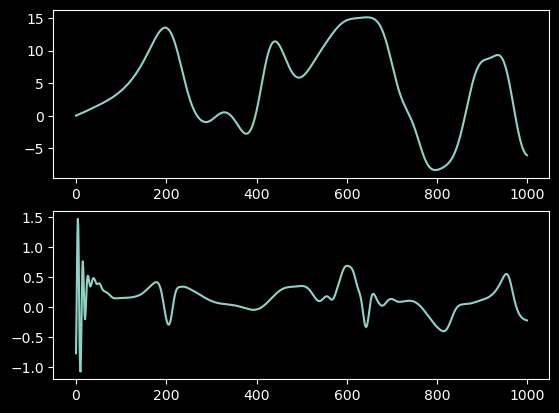

In [12]:
import matplotlib.pyplot as plt

print('shape of X', np.shape(x_store))
print('shape of Y', np.shape(y_store))


plt.subplot(2,1,1)
plt.plot(x_store[0:1000,0])

plt.subplot(2,1,2)
plt.plot(y_store[0:1000,0])



In [13]:
# Prepare dataset for neural network
import torch
import torch.nn as nn
import torch.optim as optim

X_tensor = torch.tensor(x_norm, dtype=torch.float32)
Y_tensor = torch.tensor(y_norm, dtype=torch.float32)

# shuffels data randomly, make sure x, and y stays aligned, but shuffle it temporaly to disrupt time structure
indices = np.random.permutation(np.arange(start=0, stop=X_tensor.size()[0]))

X_shuffled = X_tensor[indices]
Y_shuffled = Y_tensor[indices]




In [14]:

# Define the neural network
class Net(nn.Module):
    # input size is 8, output size is 64
    # 128 and 256 are hyper parameters and can be selected arbitrarily
    # 8 and 64 are fixed by the problem
    # nn.linear intizalized both weights and biases 
    # and initializes them randomly using xavier distribution
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(8, 128)  # Input layer: 8 -> 128
        self.fc2 = nn.Linear(128, 256)  # Hidden layer: 128 -> 256
        self.fc3 = nn.Linear(256, 64)  # Output layer: 256 -> 64

    # takes any input x and passes it through first layer
    # then applies relu activation function
    # then passes it through second layer
    # then applies relu activation function
    # then passes it through third layer without relu
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(8, 128)  # Input layer: 8 -> 128
        self.fc2 = nn.Linear(128, 256)  # Hidden layer: 128 -> 256
        self.fc3 = nn.Linear(256, 256)  # Hidden layer: 128 -> 256
        self.fc4 = nn.Linear(256, 256)  # Hidden layer: 128 -> 256
        self.fc5 = nn.Linear(256, 64)  # Output layer: 256 -> 64

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = self.fc5(x)
        return x

In [16]:

# Initialize the network, loss function, and optimizer
# cuda is used to run the network on GPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


net = Net().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
batch_size = 100
trainN = 10000
# Train the network
num_epochs = 100
LOSS = []

for epoch in range(num_epochs):
    for iter in range (0, trainN, batch_size):
        # if (iter % 1000 == 0):
        #     print('iteration number,',iter)
        batch_X = X_tensor[iter:iter+batch_size,:]
        batch_Y = Y_tensor[iter:iter+batch_size,:]
        optimizer.zero_grad() # specify that all gradients should be set to zero, otherwise they are accumulated across every iteration
        outputs = net(batch_X.to(device))
        loss = criterion(outputs, batch_Y.to(device)) # commpute loss, sutract output from target
        loss.backward() # calculate gradients for all parameters
        optimizer.step() # update parameters of the model
    LOSS.append(loss.detach().cpu().numpy())
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")





Epoch [1/100], Loss: 0.7716
Epoch [2/100], Loss: 0.7155
Epoch [3/100], Loss: 0.6984
Epoch [4/100], Loss: 0.6890
Epoch [5/100], Loss: 0.6786
Epoch [6/100], Loss: 0.6702
Epoch [7/100], Loss: 0.6623
Epoch [8/100], Loss: 0.6547
Epoch [9/100], Loss: 0.6473
Epoch [10/100], Loss: 0.6408
Epoch [11/100], Loss: 0.6332
Epoch [12/100], Loss: 0.6241
Epoch [13/100], Loss: 0.6077
Epoch [14/100], Loss: 0.5878
Epoch [15/100], Loss: 0.5619
Epoch [16/100], Loss: 0.5390
Epoch [17/100], Loss: 0.5137
Epoch [18/100], Loss: 0.4927
Epoch [19/100], Loss: 0.4773
Epoch [20/100], Loss: 0.4625
Epoch [21/100], Loss: 0.4489
Epoch [22/100], Loss: 0.4429
Epoch [23/100], Loss: 0.4375
Epoch [24/100], Loss: 0.4294
Epoch [25/100], Loss: 0.4202
Epoch [26/100], Loss: 0.4015
Epoch [27/100], Loss: 0.3947
Epoch [28/100], Loss: 0.3674
Epoch [29/100], Loss: 0.3559
Epoch [30/100], Loss: 0.3624
Epoch [31/100], Loss: 0.3437
Epoch [32/100], Loss: 0.3285
Epoch [33/100], Loss: 0.3176
Epoch [34/100], Loss: 0.2959
Epoch [35/100], Loss: 0

shape of predicted_Y (64,)


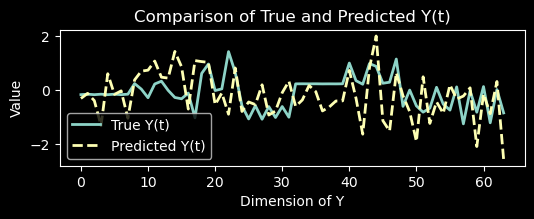

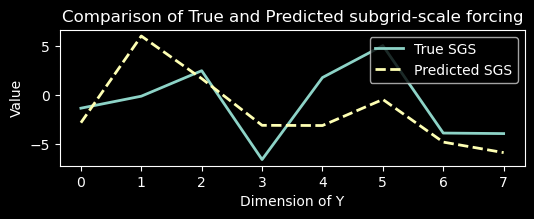

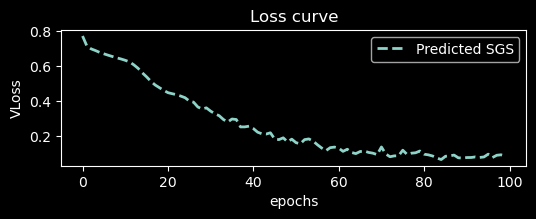

In [18]:
# Test the network on a sample
sample_id = trainN + 50
sample_X = X_tensor[sample_id]  # Take the first sample
predicted_Y = net(sample_X.float().to(device)).detach().cpu().numpy()

compute_SGS = lambda Y: np.sum(Y.reshape(8, 8), axis=1)

print('shape of predicted_Y',predicted_Y.shape)
predicted_SGS = compute_SGS(predicted_Y)
true_SGS = compute_SGS(Y_tensor[sample_id, :].numpy())


# print('shape of predicted_sgs',predicted_SGS)
# print('shape of true_SGS',true_SGS)



plt.figure(figsize=(6, 6))

plt.subplot(3,1,1)
plt.plot(Y_tensor[sample_id, :], label='True Y(t)', linewidth=2)
plt.plot(predicted_Y, '--', label='Predicted Y(t)', linewidth=2)
plt.title('Comparison of True and Predicted Y(t)')
plt.xlabel('Dimension of Y')
plt.ylabel('Value')
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
plt.subplot(3,1,2)
plt.plot(true_SGS, label='True SGS', linewidth=2)
plt.plot(predicted_SGS, '--', label='Predicted SGS', linewidth=2)
plt.title('Comparison of True and Predicted subgrid-scale forcing')
plt.xlabel('Dimension of Y')
plt.ylabel('Value')
plt.legend()
plt.show()


plt.figure(figsize=(6, 6))
plt.subplot(3,1,3)
plt.plot(LOSS, '--', label='Predicted SGS', linewidth=2)
plt.title('Loss curve')
plt.xlabel('epochs')
plt.ylabel('VLoss')
plt.legend()
plt.show()


